## 0. Basic Packages

In [1]:
import pandas as pd
#Set copy warning to off
pd.set_option('mode.chained_assignment', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nlp_preprocess import *

## 1. Data Wrangling

In [2]:
f1 = pd.read_excel("comments.xlsx", [0])[0]
f2 = pd.read_excel("comments.xlsx", [1])[1]

df = pd.concat([f1, f2]) 
df.rename(columns={"Initial Classification":"Initial_Classification"}, inplace=True)
print(df.shape)
df.head()

(584, 4)


ID    Area                                            Comment  \
0   1  Dept 1  Cerrar la brecha entre los que deciden el trab...   
1   3  Dept 1  Sobretodo, que se miren las cargas de trabajo ...   
2   4  Dept 1  1. Dar coaching a algunos Gerentes (que no sab...   
3  19  Dept 1                                                  s   
4  29  Dept 1  Mas oportunidades de crecimiento y major salar...   

  Initial_Classification  
0               Negativo  
1               Negativo  
2               Negativo  
3               Negativo  
4               Negativo

### Checking for nulls

In [3]:
#cecking for nulls
df.isna().sum()

ID                         0
Area                       0
Comment                   11
Initial_Classification     0
dtype: int64

In [4]:
#checking data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 0 to 291
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      584 non-null    int64 
 1   Area                    584 non-null    object
 2   Comment                 573 non-null    object
 3   Initial_Classification  584 non-null    object
dtypes: int64(1), object(3)
memory usage: 22.8+ KB


In [5]:
#cheking the null comments
df[df.Comment.isna()]

ID     Area Comment Initial_Classification
12    120   Dept 1     NaN               Negativo
48    561   Dept 4     NaN               Negativo
109  1280   Dept 7     NaN               Negativo
129  1475   Dept 9     NaN               Negativo
158  1768   Dept 9     NaN               Negativo
227  2481   Dept 9     NaN               Negativo
240  2587   Dept 9     NaN               Negativo
274  2850  Dept 10     NaN               Negativo
277  2887  Dept 10     NaN               Negativo
227  2481   Dept 9     NaN               Positivo
277  2887  Dept 10     NaN               Positivo

In [6]:
df.Comment = df.Comment.str.lower()

### Updating nulls with NA

In [7]:
#we will replace with the term "NA"
df.Comment[df.Comment.isna()] = "NA"

## 2. Main Functions

In [8]:
#function to check the number of times each stop word is present in comments column

#if, for instance, I consider, due to the nature of the comments and the times a stop word appears
#in the comments, I'd remove that stop word from "stop_words" list
def count_stop_words(words=np.ndarray, comments=np.ndarray):
    stop_w_count = {} 

    for w in words:
        stop_w_count[w] = sum([c.split().count(w) for c in comments])

    return sorted(stop_w_count.items(), key=lambda t: t[1], reverse=True)

#count_stop_words(stop_words, df.Comment)

In [9]:
from nltk.corpus import stopwords

#we select the spanish stop words (by default all the words with accents have them)
stop_words = stopwords.words('spanish')

#now we have the words with accents and the same ones without accents
stop_words = add_non_accents(stop_words)

#list to exclude in stop_words (excluded based in "count_stop_words" fn)
stop_w_list = ["no", "mucho", "muchos", "tiene", "tienen", "otras", "sin", "nada", "algo"
               "tanto", "alguna", "estamos", "tengan", "tenemos", "nuestros", "fuera", "algunos", "hasta"]

#exclude previous list of words from stop_words
stop_words.difference_update(stop_w_list)

## 3. Pipeline

### Detecting language

In [10]:
#we create a new column with the detected lang
#choose between langdetect or cld3. By default cld3, which works bettter (for es)
df["language"] = dect_lang(df.Comment, detector="langdetect")

In [11]:
#we check the non-snpanish ones
for c, l in zip(df.Comment[df.language!="es"], df.language[df.language!="es"]):
    print("Sentence:", c, "---->", "Lang:", l)

Sentence: s ----> Lang: sv
Sentence: prefiero no comentar ----> Lang: it
Sentence: NA ----> Lang: vi
Sentence: more alignment in priorities to focus more and accomplish better results. we try to do too much at the same time, limiting the chances of success.  ----> Lang: en
Sentence: reduce legal and compliance bureaucracy. there is a pervasive view that lawyers and risk managers can manage the business from afar. client facing employees are handcuffed and more worrisome, at times prefer not to look for better alternatives for clients afraid that they might run afoul of one of the many new rules. also, innovation is stifled by all the roadblocks and permissions needed to launch a product or service.  ----> Lang: en
Sentence: no cambiaria nada. ----> Lang: pt
Sentence: ninguna. ----> Lang: tl
Sentence: los salarios justos  ----> Lang: lt
Sentence: nada ----> Lang: so
Sentence: mejorar la paga ----> Lang: id
Sentence: NA ----> Lang: vi
Sentence: no cambiaria nada. ----> Lang: pt
Sentence:

Once we have checked the previous output we can see the english comments are well identified, and the rest are either, errors / sentences with no meaning, or spanish sentences identified as catalan, italian or other language

Therefore it is fair to consider, non-english comments as spanish comments in this case

In [12]:
#we replace non-english comments for "es" term
df.language[df.language!="en"] = "es"

In [13]:
#we re-check the list again
for c, l in zip(df.Comment[df.language!="es"], df.language[df.language!="es"]):
    print("Sentence:", c, "---->", "Lang:", l)

Sentence: more alignment in priorities to focus more and accomplish better results. we try to do too much at the same time, limiting the chances of success.  ----> Lang: en
Sentence: reduce legal and compliance bureaucracy. there is a pervasive view that lawyers and risk managers can manage the business from afar. client facing employees are handcuffed and more worrisome, at times prefer not to look for better alternatives for clients afraid that they might run afoul of one of the many new rules. also, innovation is stifled by all the roadblocks and permissions needed to launch a product or service.  ----> Lang: en
Sentence: tienen que mejorar e incentivar el work-life balance o work-life integration en vez de incentivar el burnout.  ----> Lang: en
Sentence: nothing specific ----> Lang: en
Sentence: some businesses within la empresa should be evaluated/treated differently than the rest of the company... because they are vey different in nature. employees / businesses should not be puni

### Creating Dataframe for each Language

In [14]:
df_es = df[df.language=="es"]
df_en = df[df.language=="en"]

In [15]:
print(df_es.shape)
df_es.head()

(567, 5)


ID    Area                                            Comment  \
0   1  Dept 1  cerrar la brecha entre los que deciden el trab...   
1   3  Dept 1  sobretodo, que se miren las cargas de trabajo ...   
2   4  Dept 1  1. dar coaching a algunos gerentes (que no sab...   
3  19  Dept 1                                                  s   
4  29  Dept 1  mas oportunidades de crecimiento y major salar...   

  Initial_Classification language  
0               Negativo       es  
1               Negativo       es  
2               Negativo       es  
3               Negativo       es  
4               Negativo       es

In [16]:
print(df_en.shape)
df_en.head()

(17, 5)


ID    Area                                            Comment  \
20    250  Dept 2  more alignment in priorities to focus more and...   
21    254  Dept 2  reduce legal and compliance bureaucracy. there...   
60    662  Dept 4  tienen que mejorar e incentivar el work-life b...   
63    740  Dept 4                                   nothing specific   
110  1293  Dept 7  some businesses within la empresa should be ev...   

    Initial_Classification language  
20                Negativo       en  
21                Negativo       en  
60                Negativo       en  
63                Negativo       en  
110               Negativo       en

### Positive vs Negative Comments, Preprocess & Clean

In [17]:
neg_comments_es = df_es.Comment.values[df_es.Initial_Classification=="Negativo"]
pos_comments_es = df_es.Comment.values[df_es.Initial_Classification=="Positivo"]

In [18]:
#1. set root to "no" if you don't want the root (lemma) of the word, but the original world (default="yes")
#2. set stop_w to "yes" if you want to include stop_words (default="no")

n_clean_comments_es = preprocess(clean_comments(neg_comments_es), root="no", stop_w="no", stop_words=stop_words)
p_clean_comments_es = preprocess(clean_comments(pos_comments_es), root="no", stop_w="no", stop_words=stop_words)

In [19]:
n_flatten_comments_es = [" ".join(comments) for comments in n_clean_comments_es]
p_flatten_comments_es = [" ".join(comments) for comments in p_clean_comments_es]

### Count Vectorize & TF-idf Vectorize for Wordclouds and Frequency Graphs

**TF-idf**
$$tf-idf(t, d) = tf(t, d) * log(N/(df + 1))$$

***hint: t = term, d = doc, tf = term freq, N = all docs, df = n docs containing the term***

### Unigrams Negative vs Positive Comments

##### CountVectorizer

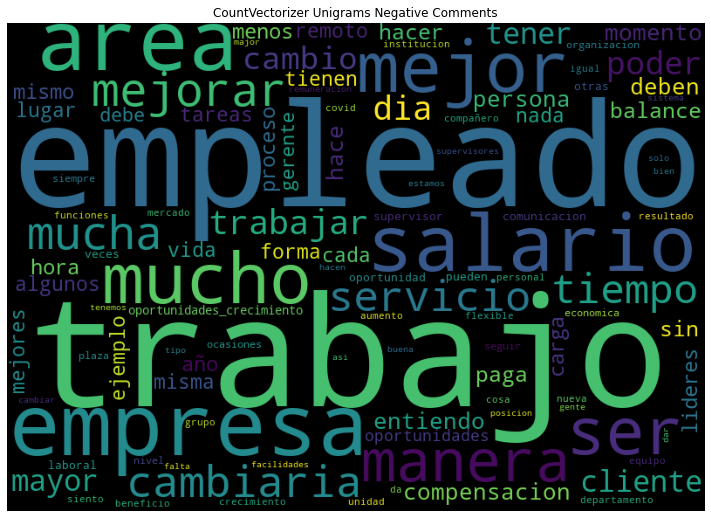

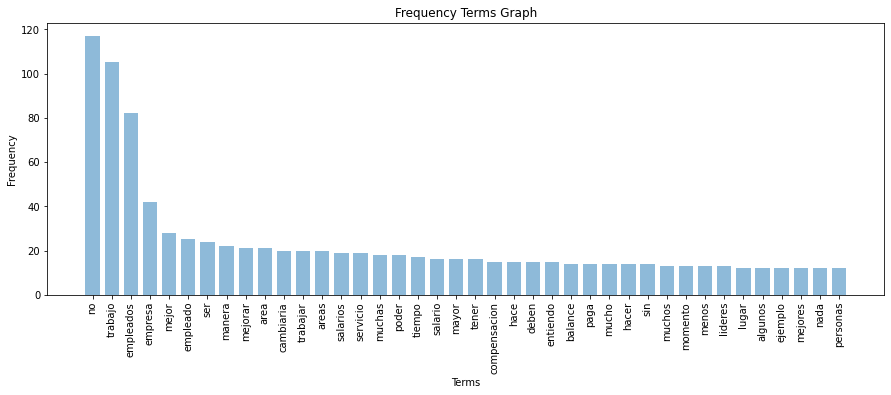

In [20]:
terms, words_df = basic_vectorizer("CountVectorizer", (1,1), n_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer=None, comments=terms, freq_dict=None, title="CountVectorizer Unigrams Negative Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

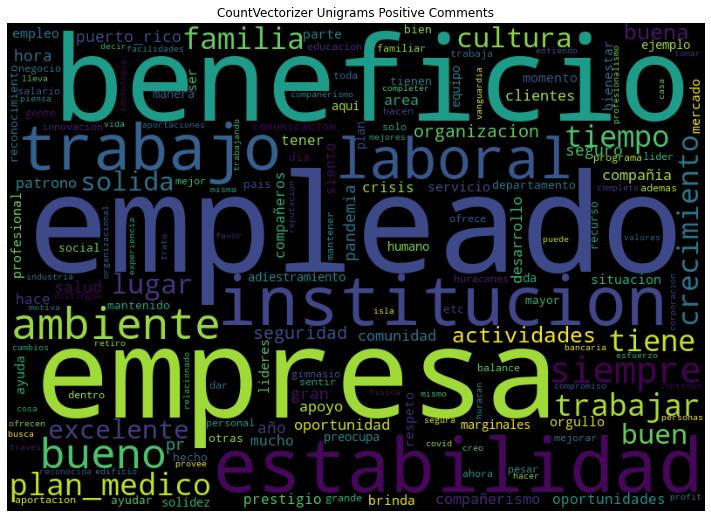

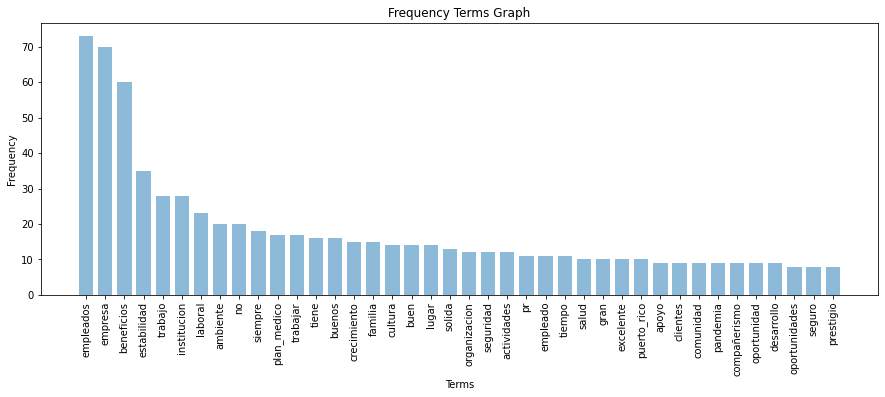

In [21]:
terms, words_df = basic_vectorizer("CountVectorizer", (1,1), p_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer=None, comments=terms, freq_dict=None, title="CountVectorizer Unigrams Positive Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

##### TfidfVectorizer

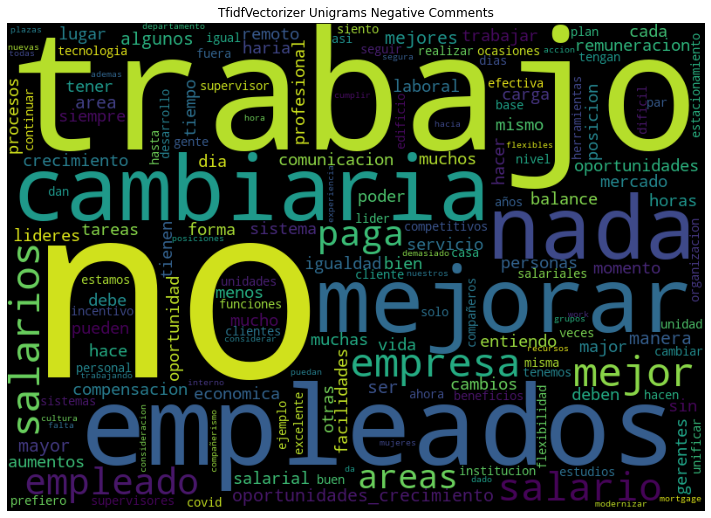

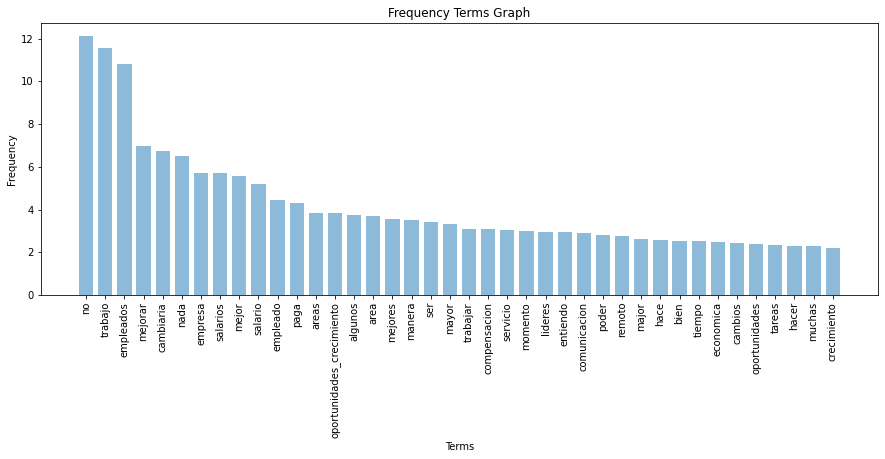

In [22]:
terms, words_df = basic_vectorizer("TfidfVectorizer", (1,1), n_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer="tf-idf", comments=None, freq_dict=terms, title="TfidfVectorizer Unigrams Negative Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

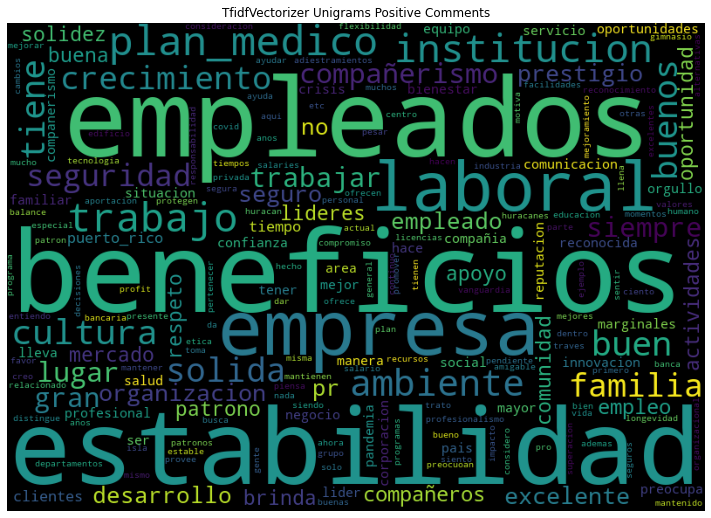

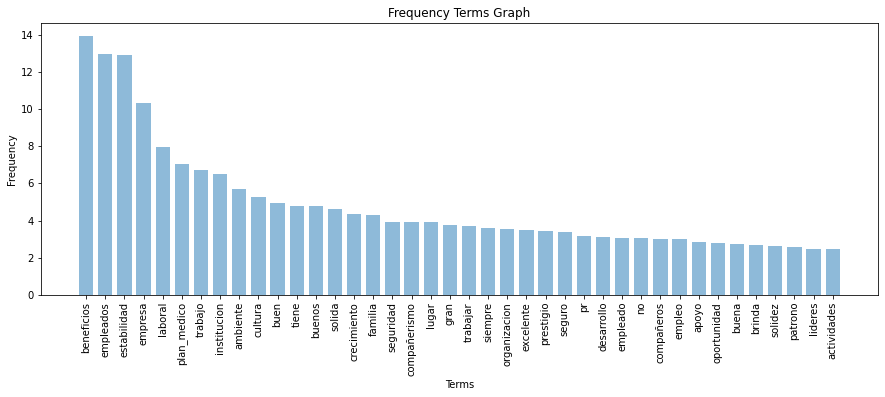

In [23]:
terms, words_df = basic_vectorizer("TfidfVectorizer", (1,1), p_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer="tf-idf", comments=None, freq_dict=terms, title="TfidfVectorizer Unigrams Positive Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

### Bigrams Negative vs Positive Comments

##### CountVectorizer

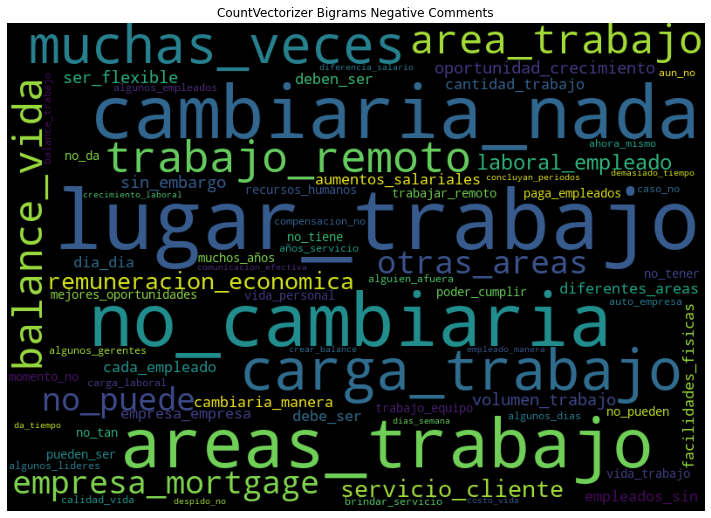

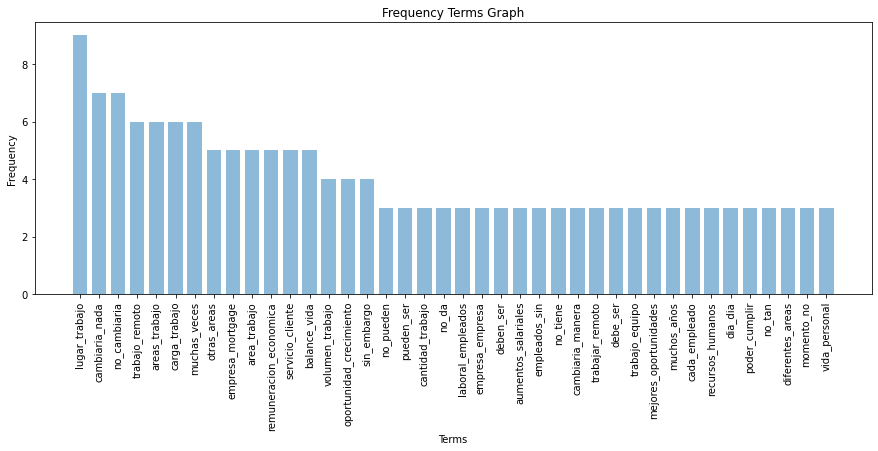

In [24]:
terms, words_df = basic_vectorizer("CountVectorizer", (2,2), n_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer=None, comments=terms, freq_dict=None, title="CountVectorizer Bigrams Negative Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

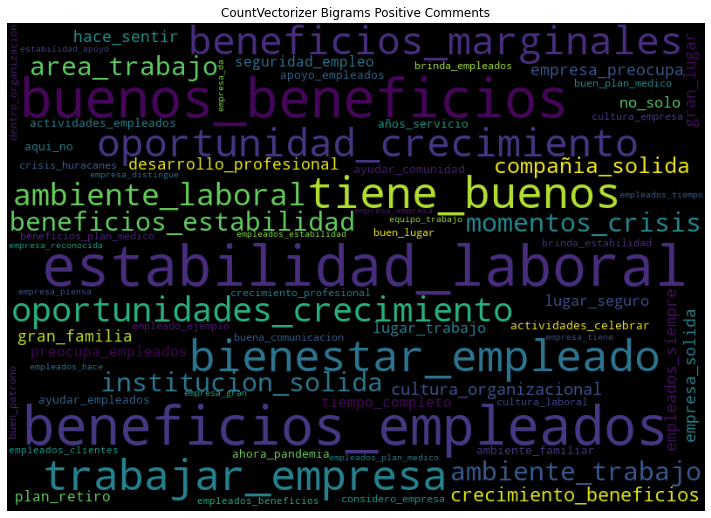

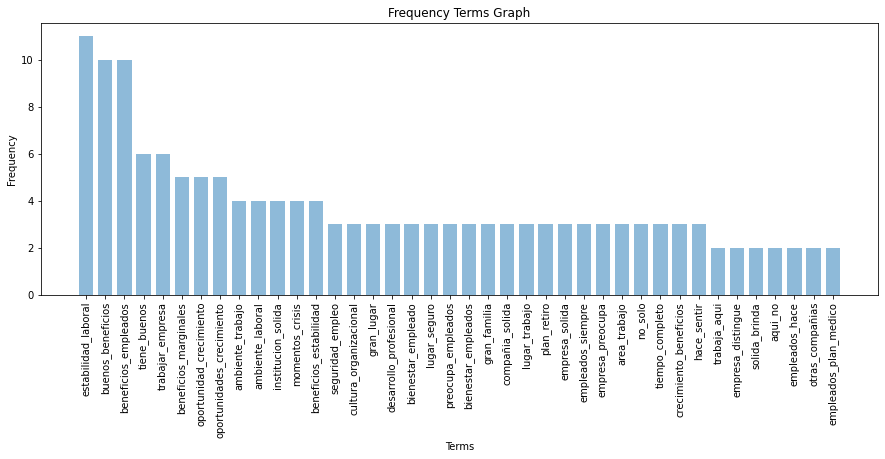

In [25]:
terms, words_df = basic_vectorizer("CountVectorizer", (2,2), p_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer=None, comments=terms, freq_dict=None, title="CountVectorizer Bigrams Positive Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

##### TfidfVectorizer

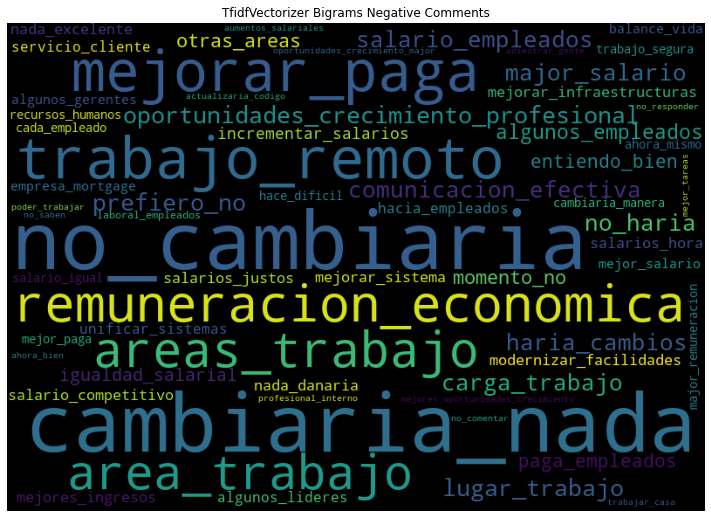

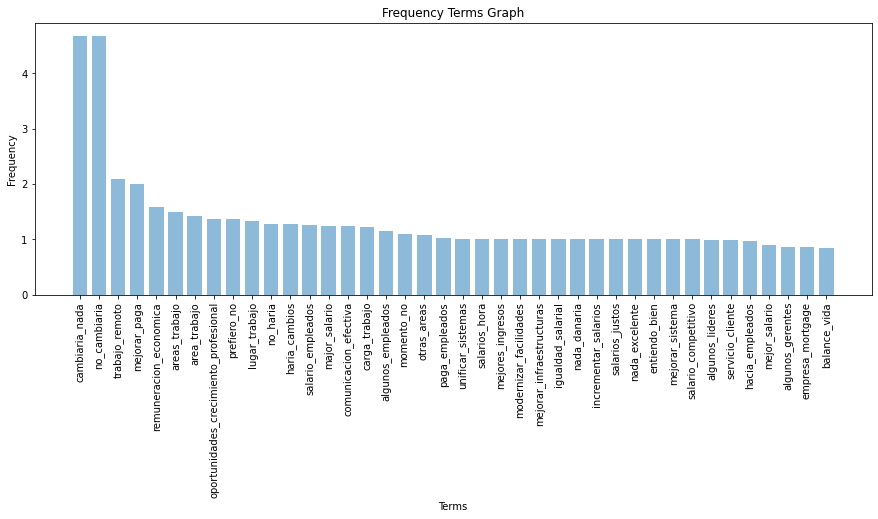

In [26]:
terms, words_df = basic_vectorizer("TfidfVectorizer", (2,2), n_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer="tf-idf", comments=None, freq_dict=terms, title="TfidfVectorizer Bigrams Negative Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

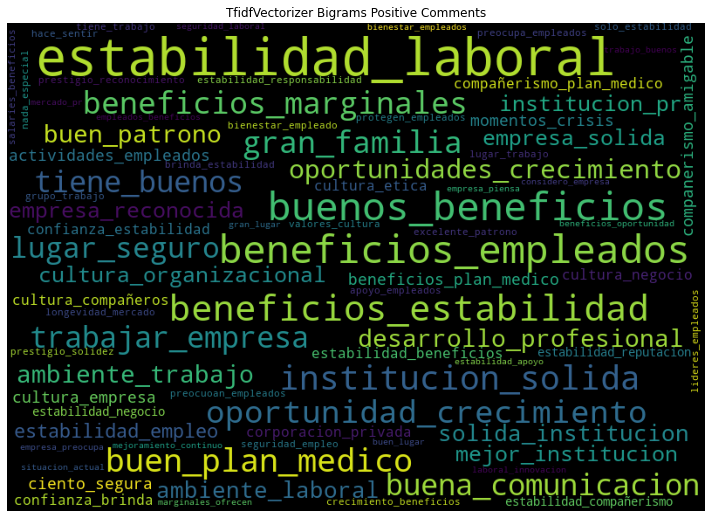

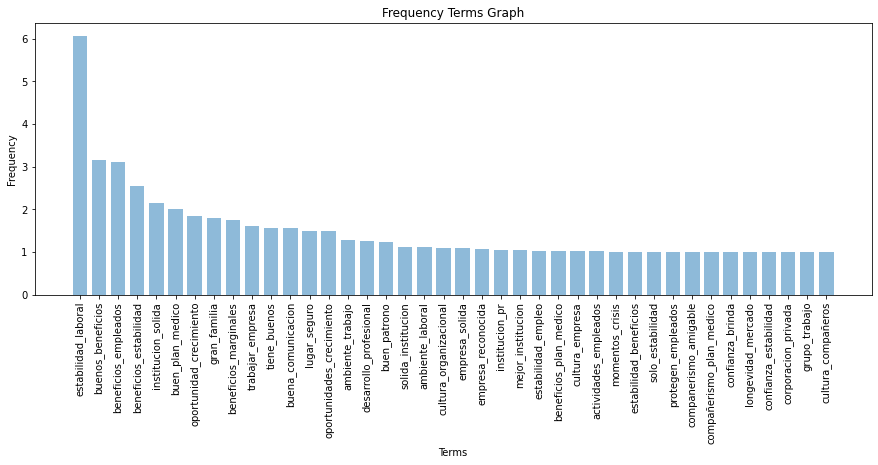

In [27]:
terms, words_df = basic_vectorizer("TfidfVectorizer", (2,2), p_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer="tf-idf", comments=None, freq_dict=terms, title="TfidfVectorizer Bigrams Positive Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

### Trigrams Negative vs Positive Comments

##### CountVectorizer

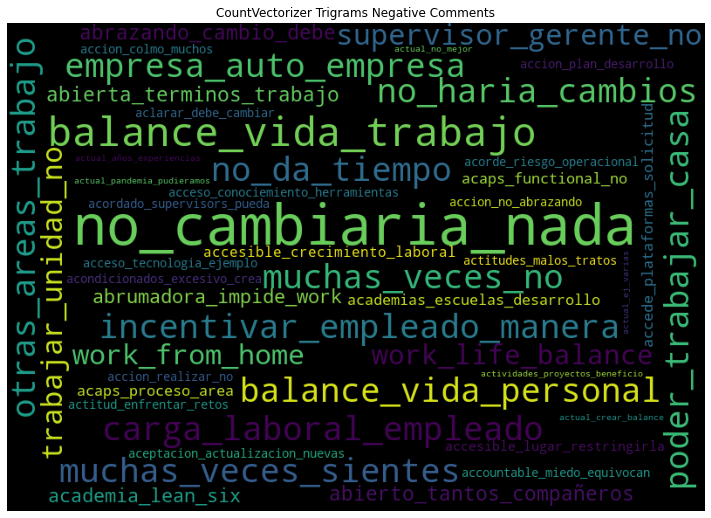

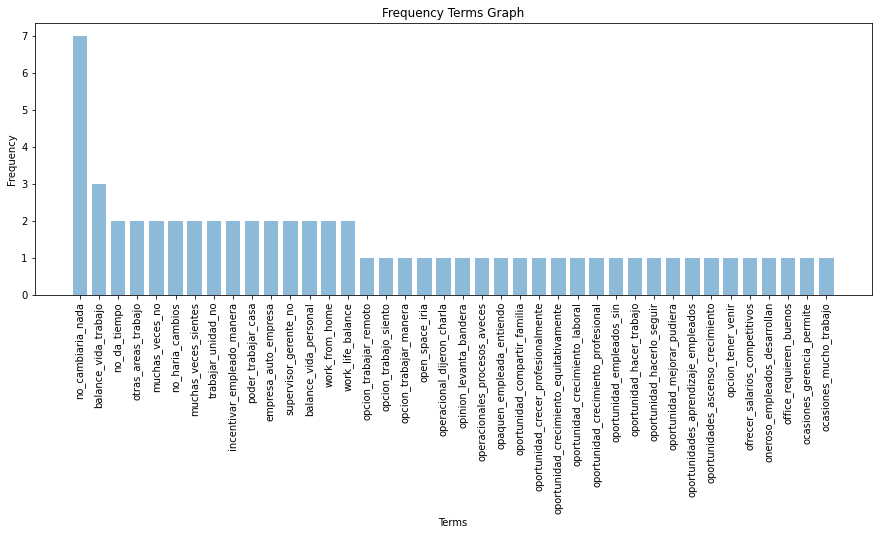

In [28]:
terms, words_df = basic_vectorizer("CountVectorizer", (3,3), n_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer=None, comments=terms, freq_dict=None, title="CountVectorizer Trigrams Negative Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

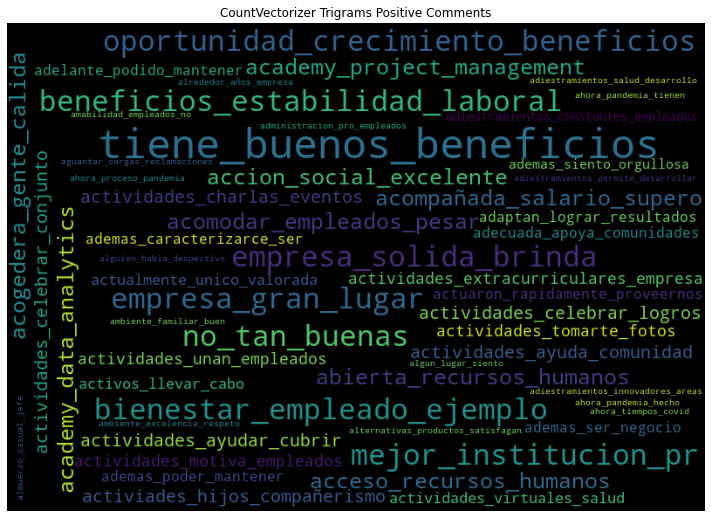

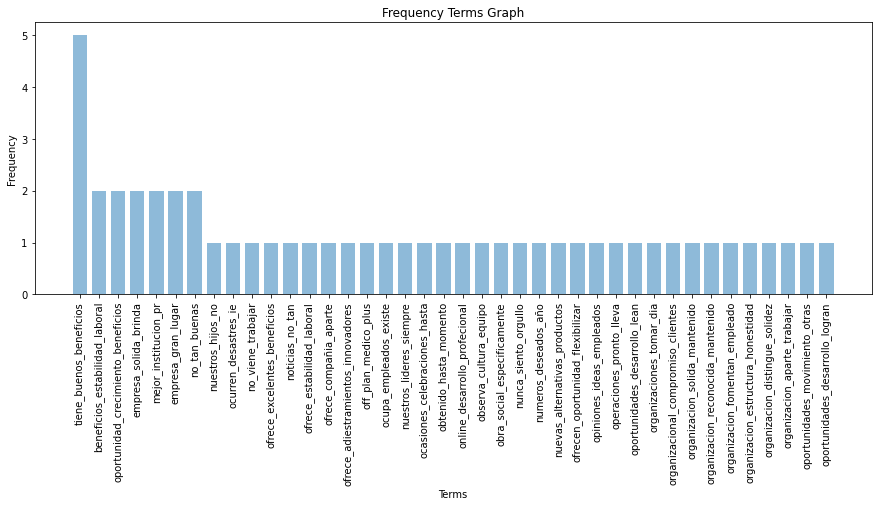

In [29]:
terms, words_df = basic_vectorizer("CountVectorizer", (3,3), p_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer=None, comments=terms, freq_dict=None, title="CountVectorizer Trigrams Positive Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

##### TfidfVectorizer

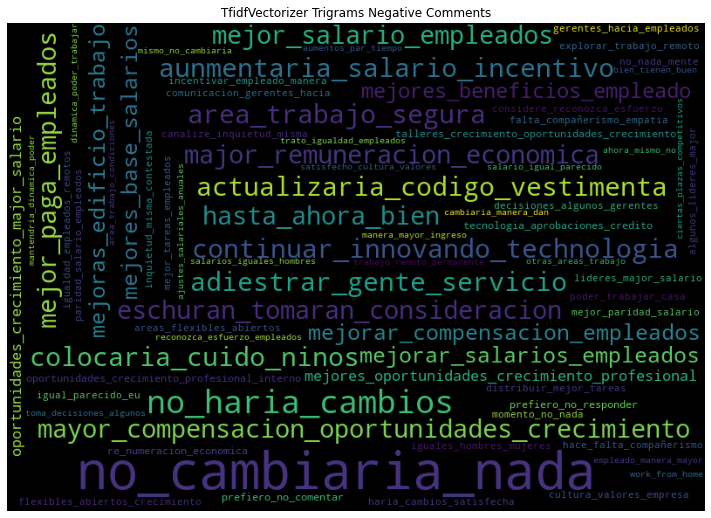

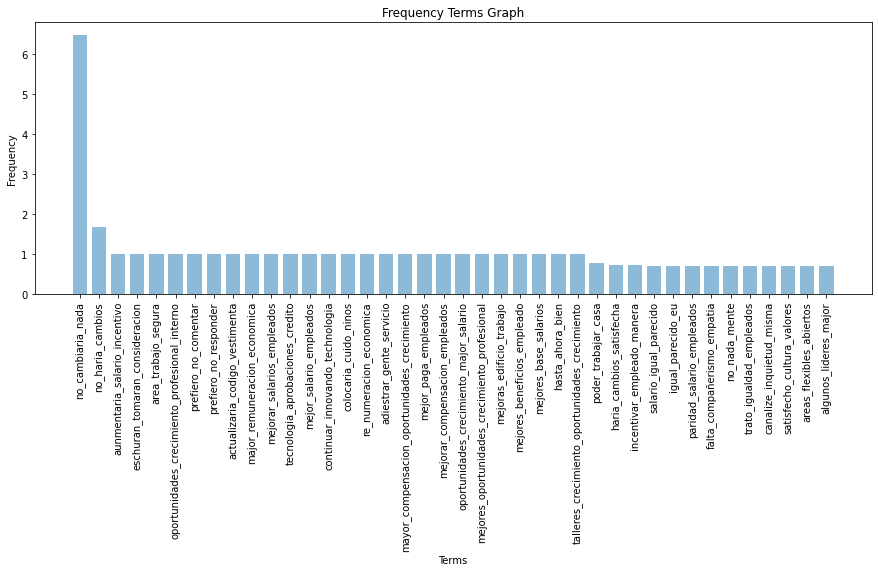

In [30]:
terms, words_df = basic_vectorizer("TfidfVectorizer", (3,3), n_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer="tf-idf", comments=None, freq_dict=terms, title="TfidfVectorizer Trigrams Negative Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))

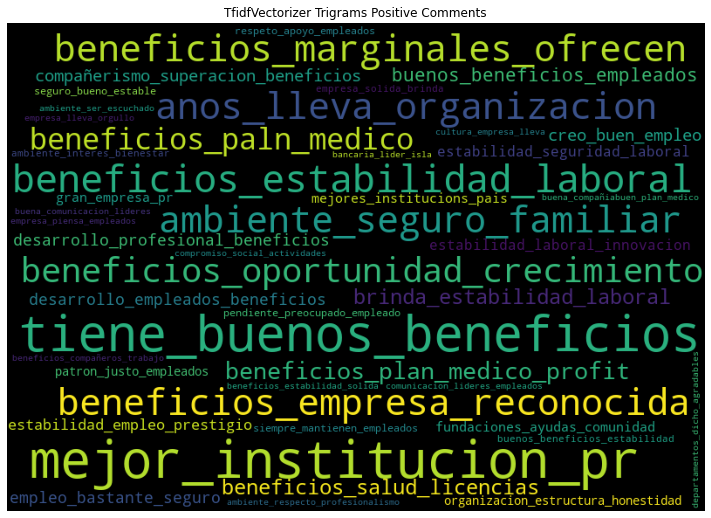

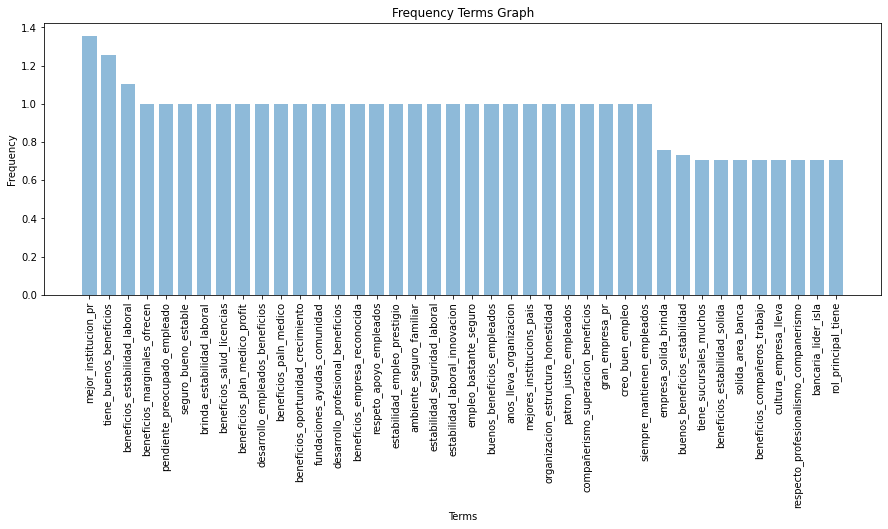

In [31]:
terms, words_df = basic_vectorizer("TfidfVectorizer", (3,3), p_flatten_comments_es)

#points to take into account:
#1. set the title (str); if comments (input) are Negative Spanish comments, set it as tittle
#2. if your terms are from tf-idf vectorizer, set vectorizer = "tf-idf", else = None (default)
#3. if your terms are from tf-idf, fill freq_dict with terms (freq_dict=terms), else let freq_dict=None
#4. if your terms are not from tf-idf, fill comments = terms

make_cloud(vectorizer="tf-idf", comments=None, freq_dict=terms, title="TfidfVectorizer Trigrams Positive Comments")

freq_graph(df=words_df, length=40, figsize=(15, 5))